# Imports

In [8]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Total Annual Spending Functions #

In [9]:
def get_spending_data(start_date, end_date, naics_code):
    """
    Retrieve spending data for a specific NAICS code within a given time period.

    Parameters:
    - start_date (str): The start date of the time period in the format "YYYY-MM-DD".
    - end_date (str): The end date of the time period in the format "YYYY-MM-DD".
    - naics_code (str): The NAICS (North American Industry Classification System) code for which spending data is to be retrieved.

    Returns:
    - dict or None: A dictionary containing spending data if the request is successful.
                   If there's an issue with the API request, an error message is printed, and None is returned.
    """
    base_url = "https://api.usaspending.gov/api/v2/search/spending_by_category/naics/"

    url = f"{base_url}{naics_code}"

    agency_object = {
        "type": "awarding",  
        "tier": "toptier",   
        "name": "Department of Defense"  
    }
    
    # Construct the payload
    payload = {
        "filters": {
            "time_period": [
                {
                    "start_date": start_date,
                    "end_date": end_date
                }
            ],
            "naics_codes": {
                "require": [naics_code]
            },
            "agencies": [agency_object]
        },
        "category": "naics",
        "limit": 5,
        "page": 1
    }

    # Make the API request
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        return None
    
def annual_spending_range(start_year, end_year, naics_code):
    """
    Retrieve spending data for a specific NAICS code within a given time period.

    Parameters:
    - start_date (str): The start date of the time period in the format "YYYY-MM-DD".
    - end_date (str): The end date of the time period in the format "YYYY-MM-DD".
    - naics_code (str): The NAICS (North American Industry Classification System) code for which spending data is to be retrieved.

    Returns:
    - dict or None: A dictionary containing spending data if the request is successful.
                   If there's an issue with the API request, an error message is printed, and None is returned.
    """
    annual_spending = {}

    for year in range(start_year, end_year):
        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"  

        result = get_spending_data(start_date, end_date, naics_code)
        
        if result and 'results' in result and len(result['results']) > 0:
            annual_spending[year] = result['results'][0]['amount']
        else:
            annual_spending[year] = 0

    return annual_spending

def plot_annual_spending(start_year, end_year, naics_code):
    """
    Plot annual spending amounts for a specific NAICS code over a range of fiscal years.

    Parameters:
    - start_year (int): The start year of the fiscal year range.
    - end_year (int): The end year of the fiscal year range.
    - naics_code (str): The NAICS (North American Industry Classification System) code for which spending data is to be plotted.

    Returns:
    - None: Plots a bar graph depicting annual spending amounts for the specified NAICS code over fiscal years.
    """
    data = annual_spending_range(start_year, end_year, naics_code)

    years = list(data.keys())
    amounts = list(data.values())
    df = pd.DataFrame({'Year': years, 'Amount': amounts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = ax = sns.barplot(x="Year", y="Amount", hue="Amount", data=df, palette="Blues_d", legend=False)

    plt.xlabel('Year')
    plt.ylabel('Amount')
    title = f'NAICS Code {naics_code} Spending Over the Years'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    plt.show()

# Highest Contracts Annually Functions #

In [10]:
def fetch_highest_contract(year, naics_code):
    """
    Fetch the highest contract awarded for a specific NAICS code within a given fiscal year.

    Parameters:
    - year (int): The fiscal year for which the highest contract is to be retrieved.
    - naics_code (str): The NAICS (North American Industry Classification System) code for which the highest contract is to be retrieved.

    Returns:
    - dict or None: A dictionary containing information about the highest contract if available.
                   If no contract is found, returns None.
    """
    url = 'https://api.usaspending.gov/api/v2/search/spending_by_award/'
    
    agency_object = {
        "type": "awarding",  
        "tier": "toptier",   
        "name": "Department of Defense"  
    }
    
    params = {
        "filters": {
            "time_period": [{"start_date": f"{year}-10-01", "end_date": f"{year+1}-09-30"}],
            "naics_codes": [naics_code],
            "agencies": [agency_object],
            "award_type_codes": ["C"]
        },
        "fields": ["Award Amount", "Recipient Name"],
        "limit": 100,  # Adjust this value based on the total number of awards
        "page": 1,
        "order": "desc",
        "sort": "Award Amount"
    }
    response = requests.post(url, json=params)
    response.raise_for_status()
    result = response.json()
    if result['results']:
        highest_contract = result['results'][0]
        return highest_contract
    else:
        return None

def get_highest_contracts(naics_code):
    """
    Retrieve the highest contracts awarded for a specific NAICS code over a range of fiscal years.

    Parameters:
    - naics_code (str): The NAICS (North American Industry Classification System) code for which highest contracts are to be retrieved.

    Returns:
    - dict: A dictionary containing information about the highest contracts for each fiscal year in the specified range.
    """
    years = range(2008, 2023)  # Adjust the year range as needed
    highest_contracts = {}
    for year in years:
        highest_contract = fetch_highest_contract(year, naics_code)
        if highest_contract:
            highest_contracts[year] = highest_contract
    return highest_contracts

def plot_largest_contracts(contracts_dict, naics_code):
    """
    Plot the highest contract values awarded for a specific NAICS code over a range of fiscal years.

    Parameters:
    - contracts_dict (dict): A dictionary containing information about the highest contracts for each fiscal year.
    - naics_code (str): The NAICS (North American Industry Classification System) code for which highest contracts are to be plotted.

    Returns:
    - None: Plots a bar graph depicting the highest contract values for the specified NAICS code over fiscal years.
    """
    years = list(contracts_dict.keys())
    highest_contracts = [float(item['Award Amount']) for item in contracts_dict.values()]
    df = pd.DataFrame({'Year': years, 'Highest Contract Value': highest_contracts})

    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x="Year", y="Highest Contract Value", hue="Highest Contract Value", data=df, palette="Blues_d", legend=False)

    plt.xlabel('Year')
    plt.ylabel('Highest Contract Value')
    title = f'NAICS Code {naics_code} Highest Contract Values'
    plt.title(title)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=9, color='black', xytext=(0, 10), textcoords='offset points')

    plt.show()

Highest Contracts and Annual Spending for NAICS Code 927110

Year 2008: Highest Contract Value - $5098420.07, Company - PARSONS GOVERNMENT SERVICES INC.
Year 2009: Highest Contract Value - $5098420.07, Company - PARSONS GOVERNMENT SERVICES INC.
Year 2010: Highest Contract Value - $5098420.07, Company - PARSONS GOVERNMENT SERVICES INC.
Year 2011: Highest Contract Value - $10004346.0, Company - TSENTR EKSPLUATATSII OBIEKTOV NAZEMNOI KOSMICHESKOI INFRASTRUKTURY FGUP
Year 2012: Highest Contract Value - $10004346.0, Company - TSENTR EKSPLUATATSII OBIEKTOV NAZEMNOI KOSMICHESKOI INFRASTRUKTURY FGUP
Year 2013: Highest Contract Value - $2609546.65, Company - NORTHROP GRUMMAN SPACE & MISSION SYSTEMS CORP.
Year 2014: Highest Contract Value - $1374021.32, Company - PARSONS GOVERNMENT SERVICES INC.
Year 2015: Highest Contract Value - $1374021.32, Company - PARSONS GOVERNMENT SERVICES INC.
Year 2016: Highest Contract Value - $538618.56, Company - JACKSON AND TULL CHARTERED ENGINEERS
Year 2017: Highest Contract Value - $538618.56, Company - JACKSON AND TULL CH

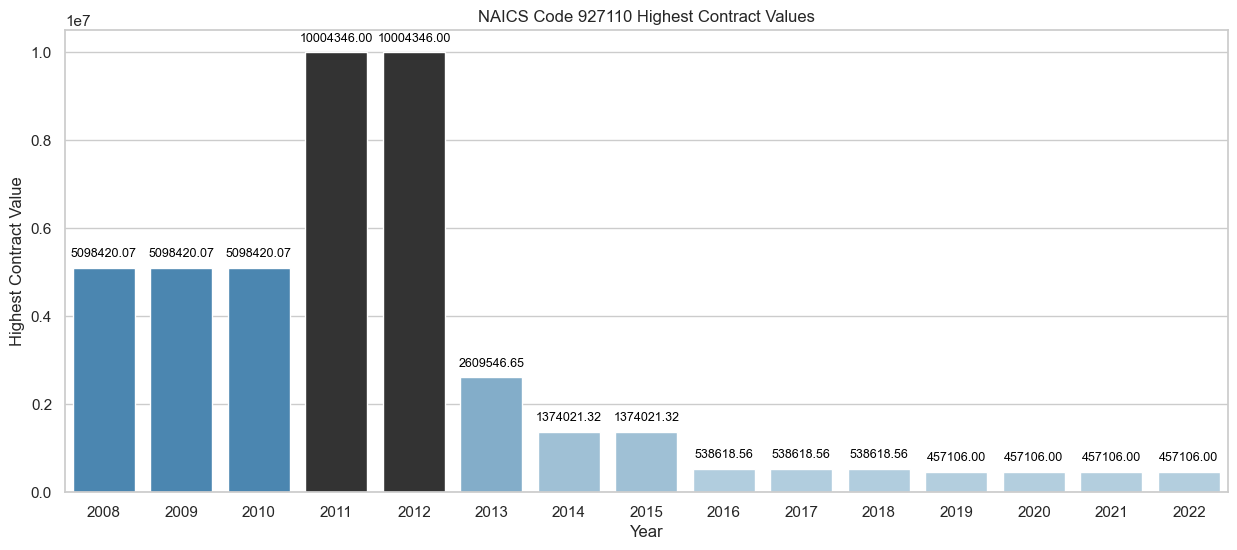

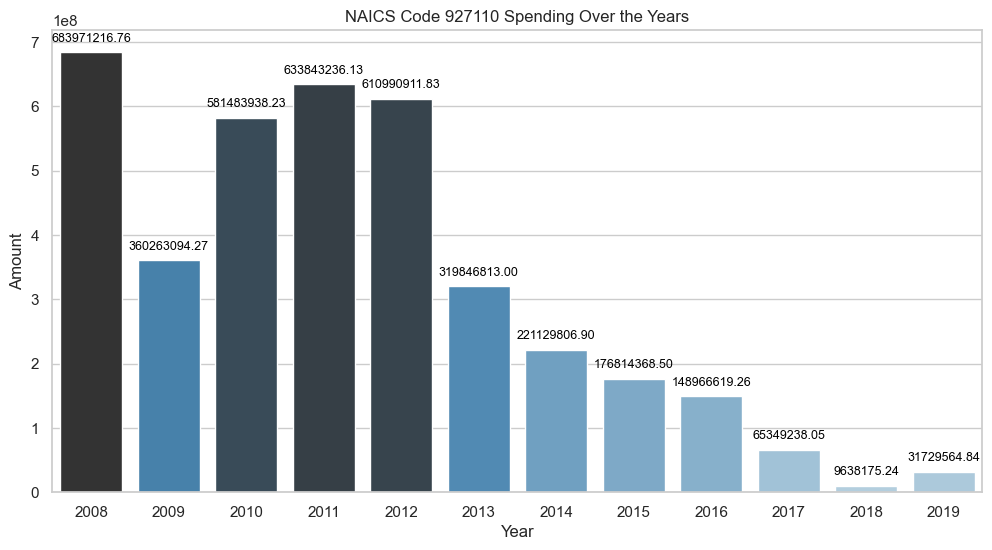

In [11]:
highest_contracts_927110 = get_highest_contracts("927110")
for year, contract in highest_contracts_927110.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
plot_largest_contracts(highest_contracts_927110, "927110")
plot_annual_spending(2008, 2020, "927110")

Highest Contracts and Annual Spending for NAICS Code 925120

Year 2009: Highest Contract Value - $7350.0, Company - ERISMAN, TAMI
Year 2010: Highest Contract Value - $7350.0, Company - ERISMAN, TAMI
Year 2011: Highest Contract Value - $7350.0, Company - ERISMAN, TAMI


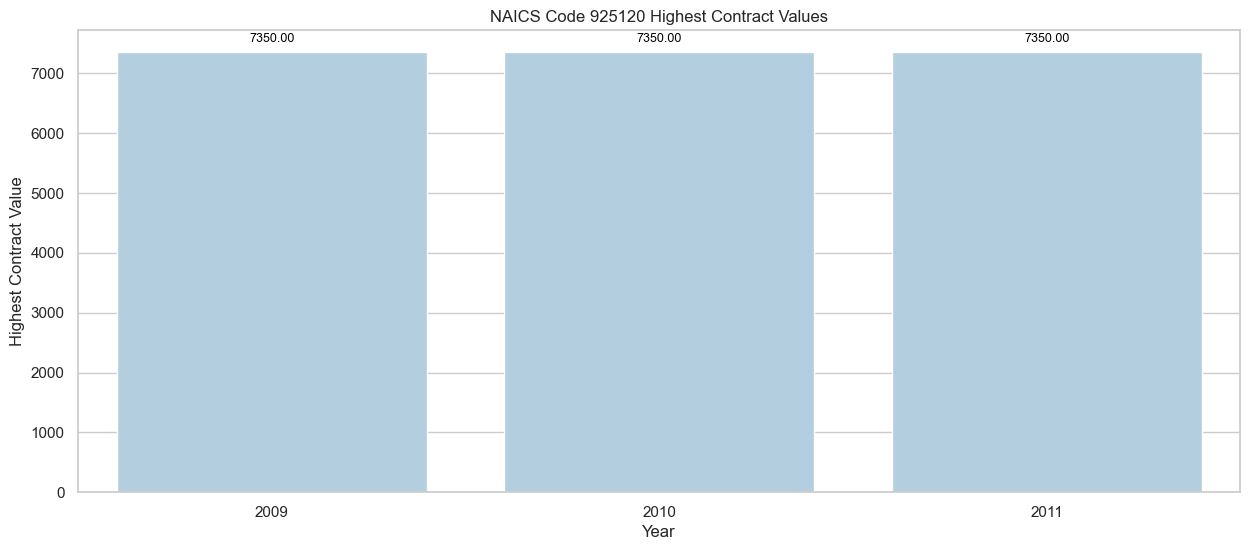

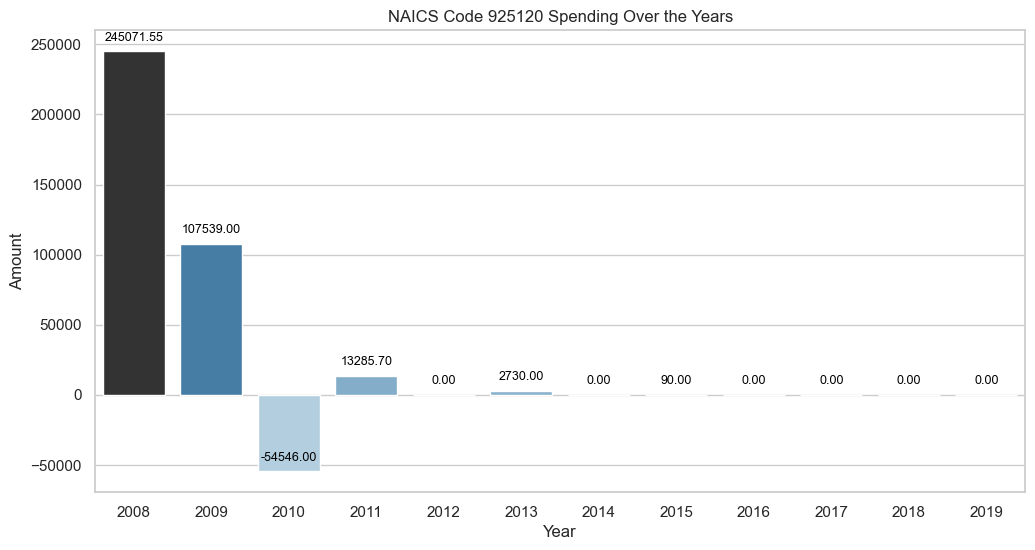

In [12]:
highest_contracts_925120 = get_highest_contracts("925120")
for year, contract in highest_contracts_925120.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
plot_largest_contracts(highest_contracts_925120, "925120")
plot_annual_spending(2008, 2020, "925120")

Highest Contracts and Annual Spending for NAICS Code 922140

Year 2008: Highest Contract Value - $453805.84, Company - COUNTY OF BELL
Year 2009: Highest Contract Value - $453805.84, Company - COUNTY OF BELL
Year 2010: Highest Contract Value - $453805.84, Company - COUNTY OF BELL
Year 2011: Highest Contract Value - $453805.84, Company - COUNTY OF BELL
Year 2012: Highest Contract Value - $270120.22, Company - COUNTY OF BELL
Year 2013: Highest Contract Value - $270120.22, Company - COUNTY OF BELL
Year 2014: Highest Contract Value - $270120.22, Company - COUNTY OF BELL
Year 2015: Highest Contract Value - $399945.0, Company - COUNTY OF BELL
Year 2016: Highest Contract Value - $270120.22, Company - COUNTY OF BELL
Year 2017: Highest Contract Value - $263066.05, Company - COUNTY OF BELL
Year 2018: Highest Contract Value - $263066.05, Company - COUNTY OF BELL
Year 2019: Highest Contract Value - $211074.18, Company - COUNTY OF BELL
Year 2020: Highest Contract Value - $299897.6, Company - COUNTY OF BELL
Year 2021: Highest Contract Value - $104645.12, Compa

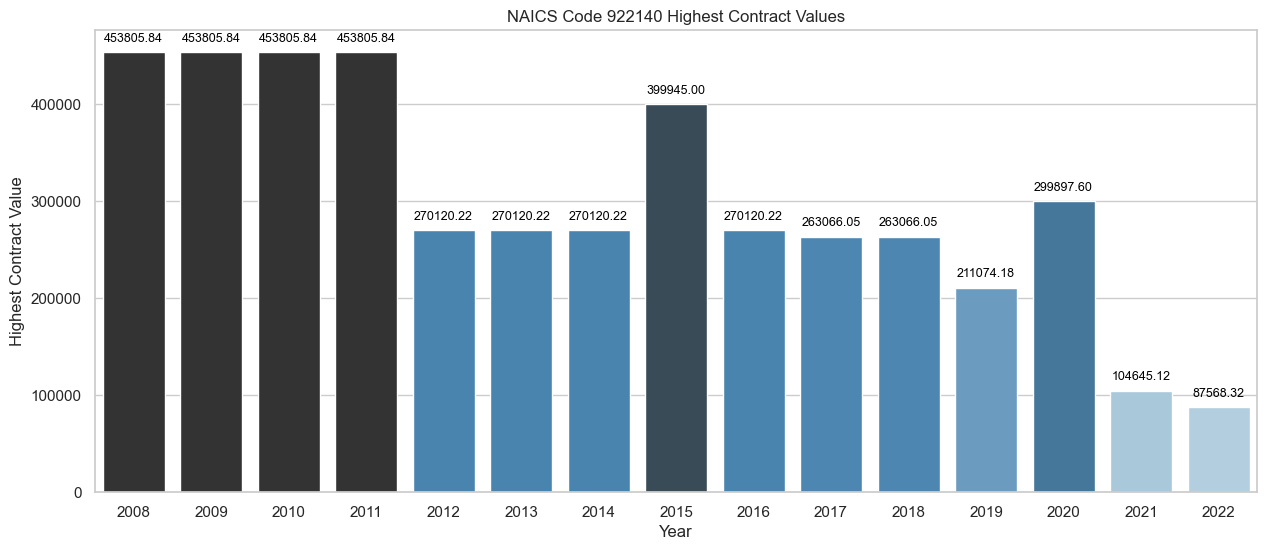

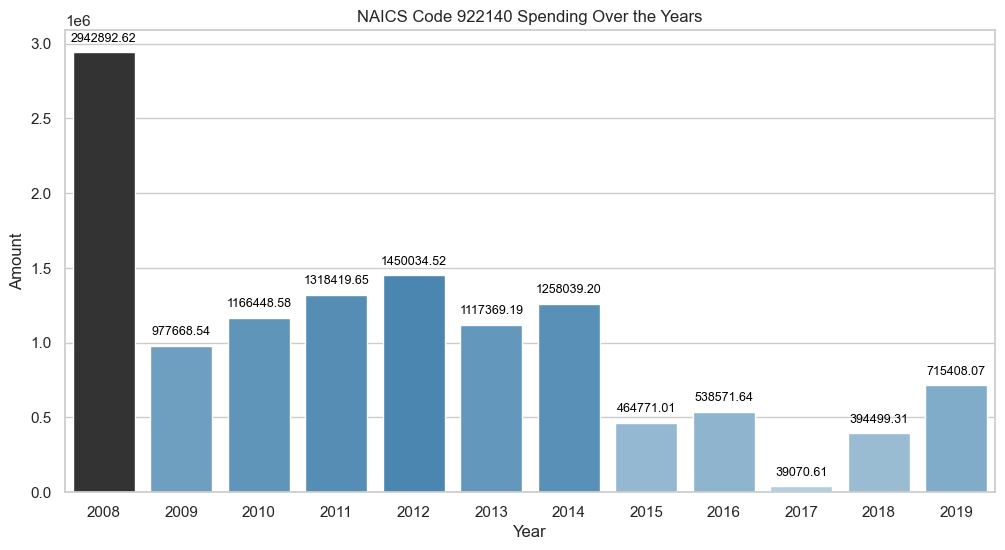

In [13]:
highest_contracts_922140 = get_highest_contracts("922140")
for year, contract in highest_contracts_922140.items():
    print(f"Year {year}: Highest Contract Value - ${contract['Award Amount']}, Company - {contract['Recipient Name']}")
plot_largest_contracts(highest_contracts_922140, "922140")
plot_annual_spending(2008, 2020, "922140")